In [1]:
using ModelingToolkit
using OrdinaryDiffEq
using DifferentialEquations
using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using AlgebraicPetri.BilayerNetworks

using Plots
using Random

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
import Catlab.CategoricalAlgebra: migrate!
using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms

using JSON

using Dates

In [2]:
make_depvar(p,t) = :($p($t))

make_depvar (generic function with 1 method)

In [3]:
function compile(bn::Union{AbstractLabelledBilayerNetwork, AbstractBilayerNetwork})
  varstmt = :(@variables t)
  varnames = bn[:variable]
  append!(varstmt.args, make_depvar.(bn[:variable], :t))

  paramstmt = :(@parameters)
  params = bn[:parameter]
  append!(paramstmt.args, bn[:parameter])

  diffstmt = :(_D_ = Differential(t))

  ϕs = map(parts(bn, :Box)) do b
    vars = map(incident(bn, b,:call)) do i
      j = bn[i, :arg]
      return bn[j, :variable]
    end
    p = :(*($(bn[b, :parameter])))
    append!(p.args, vars)
    return :($(Symbol("ϕ$b")) = $p)
  end

  infs = map(parts(bn, :Qout)) do tv
    vars = map(incident(bn, tv, :infusion)) do wa
      j = bn[wa, :influx]
      return Symbol("ϕ$j")
    end
    p = :(+())
    append!(p.args, vars)

    # same for the outfluxes
    vars = map(incident(bn, tv, :effusion)) do wn
      j = bn[wn, :efflux]
      return :(- $(Symbol("ϕ$j")))
    end
    append!(p.args, vars)
    return p
  end

  zparts = zip(bn[:tanvar], infs)

  eqns = [:(_D_($tanvar) ~ $rhs) for (tanvar, rhs) in zparts]
  eq = :([])
  append!(eq.args, eqns)
  eqnstmt = :(eqs = $eq)

  varnameexpr = Expr(:tuple, varnames...)
  parnameexpr = Expr(:tuple, params...)

  return quote
    $varstmt
    $paramstmt
    $diffstmt
    $(ϕs...)
    $eqnstmt
    return $varnameexpr, $parnameexpr, ODESystem(eqs, t, name=:PetriNet)
  end
end

compile (generic function with 1 method)

In [4]:
@present TheoryOrigMIRANet <: SchLabelledReactionNet begin
    MID::AttrType
    MCTX::AttrType
    Template::AttrType
    mira_ids::Attr(S, MID)
    mira_context::Attr(S, MCTX)
    mira_initial_value::Attr(S, Concentration)
    template_type::Attr(T, Template)
    parameter_name::Attr(T, Name)
    parameter_value::Attr(T, Rate)
end
@abstract_acset_type AbstractOrigMIRANet <: AbstractLabelledReactionNet
@acset_type OrigMIRANet(TheoryOrigMIRANet) <: AbstractOrigMIRANet

OrigMIRANet

In [5]:
function mtk_simulate(jsonfile, states, params, timespan)
    mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, jsonfile)
    map!(Symbol, mira[:sname], mira[:sname])
    map!(Symbol, mira[:tname], mira[:tname])
    bnsir = LabelledBilayerNetwork()
    migrate!(bnsir, LabelledPetriNet(mira))
    mdl = eval(compile(bnsir))
    prob = ODEProblem(mdl[3], states, timespan, params)
    soln = solve(prob)
    return soln
end

mtk_simulate (generic function with 1 method)

In [6]:
soln = mtk_simulate("./thin-thread-examples/biomodels/BIOMD0000000971/model_petri.json", [1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], rand(13), (0, 5))

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 15-element Vector{Float64}:
 0.0
 0.010907610311376315
 0.0804235330564122
 0.20379953749934845
 0.3560590295637992
 0.5539966196273575
 0.7960333014615527
 1.0927746572126076
 1.447229072459317
 1.8687274634008455
 2.3650829183423205
 2.9482419259726367
 3.6318348964630847
 4.425247425436112
 5.0
u: 15-element Vector{Vector{Float64}}:
 [1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9999999975551589, 0.24833781388640289, 0.00028359095230819884, 0.0013751854819359821, 3.4320862991352855e-10, 7.439250222148232e-7, 2.2419597043033037e-6, 1.4006206055656792e-9]
 [0.9999990867097502, 0.23800127834489387, 0.0019616194572696557, 0.009857789076870448, 1.2692591894699115e-7, 3.760265265123305e-5, 0.00011934086504609906, 5.179803698935437e-7]
 [0.9999868712700677, 0.22070707679501175, 0.004440003238131428, 0.023766150464335514, 1.791322082691212e-6, 0.000212400

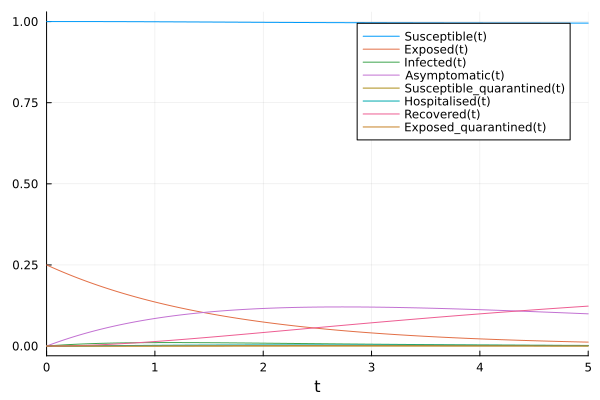

In [7]:
plot(soln)

In [252]:
# Set RNG seed
Random.seed!(1234);

# Constants
num_timesteps = 60
timespan = (0, num_timesteps)
num_runs = 10

# Run simulation for every available model

for source in ["biomodels", "starter-kit"]

    for model_dir in readdir(joinpath("./thin-thread-examples", source), join = true)

        root, dirs, files = first(walkdir(model_dir))

        if "model_petri.json" in files

            p_model = joinpath(model_dir, "model_petri.json")
            model = JSON.parsefile(p_model)    
            num_states = length(model["S"])
            num_params = length(model["T"])

            # Iterate over runs
            for i_run in 0:num_runs

                # Run with default values in model
                if i_run == 0

                    mmt_params = JSON.parsefile(joinpath(model_dir, "model_mmt_parameters.json"))
                    mmt_initials = JSON.parsefile(joinpath(model_dir, "model_mmt_initials.json"))

                    # Get default model parameter values
                    params = Vector{Float64}(undef, length(model["T"]))
                    for i in 1:length(model["T"])    
                        if ~isnothing(model["T"][i]["parameter_value"])
                            if typeof(model["T"][i]["parameter_value"]) == typeof(params[i])
                                params[i] = model["T"][i]["parameter_value"]
                            else
                                params[i] = parse(Float64, model["T"][i]["parameter_value"])
                            end
                        else
                            params[i] = 0.0
                        end
                    end

                    # Get default initial condition values
                    initials = Vector{Float64}(undef, length(model["S"]))
                    for i in 1:length(model["S"])
                        if "mira_initial_value" in keys(model["S"][i])
                            if ~isnothing(model["S"][i]["mira_initial_value"])
                                if typeof(model["S"][i]["mira_initial_value"]) == typeof(initials[i])
                                    initials[i] = model["S"][i]["mira_initial_value"]
                                else
                                    initials[i] = parse(Float64, model["S"][i]["mira_initial_value"])
                                end
                            else
                                initials[i] = 0.0
                            end
                        else
                            initials[i] = 0.0
                        end
                    end

                # Run with random values
                else

                    initials = rand(num_states)
                    initials = initials / sum(initials)
                    
                    params = rand(num_params)

                end

                # Run simulation
                soln = mtk_simulate(p_model, initials, params, timespan)

                # Map results to output format  
                output = deepcopy(mmt_initials["initials"])
                for i in 1:length(model["S"])
                    output[model["S"][i]["sname"]]["value"] = Vector{Float64}(undef, length(soln.t))
                    for t in 1:length(soln.t)
                        output[model["S"][i]["sname"]]["value"][t] = soln.u[t][i]
                    end
                end

                # Time
                df = Dates.DateFormat("yyyy-mm-ddTHH:MM:SS")
                start_datetime = DateTime(2022, 1, 1, 0, 0)
                delta = DateTime(2022, 1, 2, 0, 0) - DateTime(2022, 1, 1, 0, 0)
                output["_time"] = Dict("name" => "time", "identifiers" => Dict(), "context" => Dict(), "value" => Vector{String}(undef, length(soln.t)))

                for t in 1:length(soln.t)
                    output["_time"]["value"][t] = Dates.format(start_datetime + delta * (t - 1), df)
                end

                # Convert `params` to MIRA file format
                params_data = Dict("parameters" => Dict())
                for i in 1:length(model["T"])
                    k = model["T"][i]["parameter_name"]
                    if k in keys(mmt_params["parameters"])
                        params_data["parameters"][k] = mmt_params["parameters"][k]
                        params_data["parameters"][k]["value"] = params[i]
                    else
                        params_data["parameters"][model["T"][i]["tname"]] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => params[i])
                    end
                end

                # Convert `initials` to MIRA file format
                initials_data = Dict("initials" => Dict())
                for i in 1:length(model["S"])
                    k = model["S"][i]["sname"]
                    if k in keys(mmt_initials["initials"])
                        initials_data["initials"][k] = mmt_initials["initials"][k]
                        initials_data["initials"][k]["value"] = initials[i]
                    else
                        initials_data["initials"][k] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => initials[i])
                    end
                end 
                
                # Make output directory
                dir_name = string(i_run)
                p_output = joinpath(model_dir, "runs", dir_name)
                if ~isdir(p_output)
                    mkpath(p_output)
                end
                
                # Serialize and write to file
                open(joinpath(p_output, "parameters.json"), "w") do f
                    JSON.print(f, params_data)
                end

                open(joinpath(p_output, "initials.json"), "w") do f
                    JSON.print(f, initials_data)
                end

                open(joinpath(p_output, "output.json"), "w") do f
                    JSON.print(f, output)
                end

            end

            print("Success: $model_dir\n")

        else

            print("Error: missing `model_petri.json` in $model_dir\n")

        end
    end
end

Success: ./thin-thread-examples/biomodels/BIOMD0000000955
Success: ./thin-thread-examples/biomodels/BIOMD0000000956
Success: ./thin-thread-examples/biomodels/BIOMD0000000957
Success: ./thin-thread-examples/biomodels/BIOMD0000000958
Success: ./thin-thread-examples/biomodels/BIOMD0000000960
Success: ./thin-thread-examples/biomodels/BIOMD0000000962
Success: ./thin-thread-examples/biomodels/BIOMD0000000963
Success: ./thin-thread-examples/biomodels/BIOMD0000000964
Success: ./thin-thread-examples/biomodels/BIOMD0000000969
Success: ./thin-thread-examples/biomodels/BIOMD0000000970
Success: ./thin-thread-examples/biomodels/BIOMD0000000971
Success: ./thin-thread-examples/biomodels/BIOMD0000000972
Success: ./thin-thread-examples/biomodels/BIOMD0000000974
Success: ./thin-thread-examples/biomodels/BIOMD0000000976
Success: ./thin-thread-examples/biomodels/BIOMD0000000977
Success: ./thin-thread-examples/biomodels/BIOMD0000000978
Success: ./thin-thread-examples/biomodels/BIOMD0000000979
Success: ./thi